# 12. 完全な機械学習パイプライン (Complete ML Pipeline)

## 概要
このノートブックでは、データ読み込みから本番環境へのデプロイまでの完全な機械学習パイプラインを構築します。

## 学習目標
- Pipelineを使った前処理とモデルの統合
- パイプライン内でのハイパーパラメータチューニング
- joblibを使ったモデルの永続化
- 本番環境向けの予測関数の実装
- 完全なMLワークフローのベストプラクティス

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import joblib
import os
from datetime import datetime

# 日本語フォント設定（必要に応じて）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 乱数シード設定
np.random.seed(42)

## 1. Pipelineの基礎

### Pipelineとは
Pipelineは、データの前処理とモデル学習を一つのワークフローにまとめる機能です。

### Pipelineの利点
1. **コードの簡潔性**: 複数のステップを一つのオブジェクトで管理
2. **データリーク防止**: cross-validationで前処理が正しく適用される
3. **再現性の向上**: 前処理パラメータが学習データから計算され保存される
4. **デプロイの容易性**: 一つのオブジェクトとして保存・読み込み可能

In [2]:
# データ読み込み（分類タスク）
cancer_data = load_breast_cancer()
X_cancer = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y_cancer = cancer_data.target

# データ分割
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

print(f"訓練データサイズ: {X_train_c.shape}")
print(f"テストデータサイズ: {X_test_c.shape}")

訓練データサイズ: (455, 30)
テストデータサイズ: (114, 30)


In [3]:
# 基本的なPipelineの構築
pipeline_basic = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
])

# Pipelineの学習
pipeline_basic.fit(X_train_c, y_train_c)

# Pipelineで予測
y_pred_basic = pipeline_basic.predict(X_test_c)
accuracy_basic = pipeline_basic.score(X_test_c, y_test_c)

print(f"基本的なPipelineの精度: {accuracy_basic:.4f}")
print("\nPipelineのステップ:")
print(pipeline_basic.steps)

基本的なPipelineの精度: 0.9474

Pipelineのステップ:
[('scaler', StandardScaler()), ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))]


## 2. パイプライン内でのハイパーパラメータチューニング

### パイプラインパラメータの指定方法
パイプライン内の各ステップのパラメータは `<ステップ名>__<パラメータ名>` の形式で指定します。

In [4]:
# GridSearchCVでパイプライン全体を最適化
pipeline_tuned = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=500, random_state=42))
])

# パラメータグリッド（前処理とモデルの両方）
param_grid = {
    # Scalerの選択（StandardScaler or MinMaxScaler）
    'scaler': [StandardScaler(), MinMaxScaler()],
    # MLPのパラメータ
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01]
}

# GridSearchCV実行
grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV実行中...")
grid_search.fit(X_train_c, y_train_c)

print(f"\n最良スコア: {grid_search.best_score_:.4f}")
print(f"最良パラメータ:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

GridSearchCV実行中...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



最良スコア: 0.9802
最良パラメータ:
  classifier__activation: relu
  classifier__alpha: 0.0001
  classifier__hidden_layer_sizes: (50,)
  classifier__learning_rate_init: 0.001
  scaler: StandardScaler()


In [5]:
# テストデータでの評価
best_pipeline = grid_search.best_estimator_
y_pred_tuned = best_pipeline.predict(X_test_c)
accuracy_tuned = best_pipeline.score(X_test_c, y_test_c)

print(f"チューニング後のテスト精度: {accuracy_tuned:.4f}")
print("\n詳細な分類レポート:")
print(classification_report(y_test_c, y_pred_tuned, target_names=cancer_data.target_names))

チューニング後のテスト精度: 0.9561

詳細な分類レポート:
              precision    recall  f1-score   support

   malignant       0.91      0.98      0.94        42
      benign       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



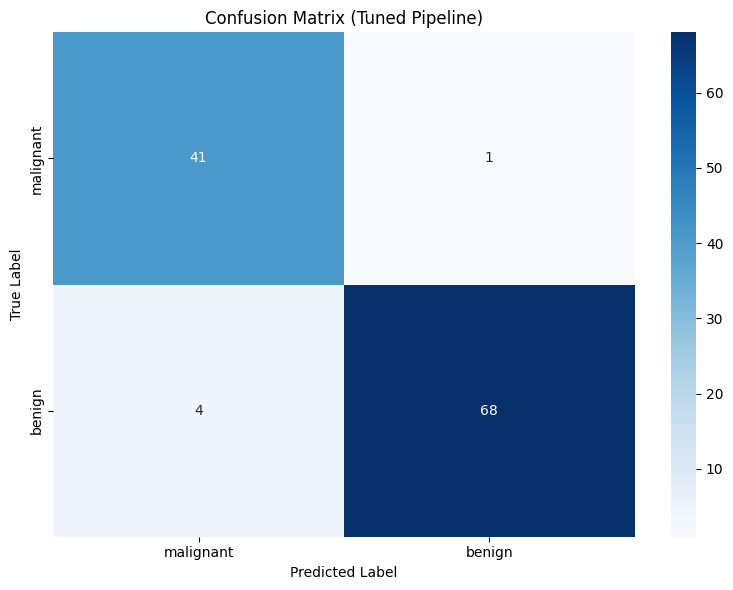


正解数: 109 / 114


In [6]:
# 混同行列の可視化
cm = confusion_matrix(y_test_c, y_pred_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer_data.target_names,
            yticklabels=cancer_data.target_names)
plt.title('Confusion Matrix (Tuned Pipeline)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\n正解数: {cm.diagonal().sum()} / {cm.sum()}")

## 3. 複雑なパイプライン: 特徴量エンジニアリング

### 多項式特徴量の追加
パイプラインに特徴量生成ステップを追加できます。

In [7]:
# Synthetic housing data (replacing fetch_california_housing due to network restrictions)
np.random.seed(42)
X_housing_synthetic, y_housing_synthetic = make_regression(
    n_samples=1000, n_features=8, n_informative=8, noise=15, random_state=42
)
# Create a namespace object to mimic the dataset structure
class SyntheticHousingData:
    def __init__(self):
        self.data = X_housing_synthetic
        self.target = y_housing_synthetic
        # Scale target to realistic housing prices
        self.target = (self.target - self.target.min()) / (self.target.max() - self.target.min()) * 4 + 0.5
        self.feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                              'Population', 'AveOccup', 'Latitude', 'Longitude']

housing_data = SyntheticHousingData()
X_housing = pd.DataFrame(housing_data.data[:1000], columns=housing_data.feature_names)
y_housing = housing_data.target[:1000]

# データ分割
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

print(f"回帰データサイズ: {X_train_h.shape}")


回帰データサイズ: (800, 8)


In [8]:
# 多項式特徴量を含むパイプライン
pipeline_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
])

# 通常のパイプライン（比較用）
pipeline_normal = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
])

# 両方のパイプラインを学習
print("通常のパイプライン学習中...")
pipeline_normal.fit(X_train_h, y_train_h)
print("多項式特徴量パイプライン学習中...")
pipeline_poly.fit(X_train_h, y_train_h)

# 予測と評価
y_pred_normal = pipeline_normal.predict(X_test_h)
y_pred_poly = pipeline_poly.predict(X_test_h)

r2_normal = r2_score(y_test_h, y_pred_normal)
r2_poly = r2_score(y_test_h, y_pred_poly)
rmse_normal = np.sqrt(mean_squared_error(y_test_h, y_pred_normal))
rmse_poly = np.sqrt(mean_squared_error(y_test_h, y_pred_poly))

print(f"\n通常のパイプライン - R²: {r2_normal:.4f}, RMSE: {rmse_normal:.4f}")
print(f"多項式特徴量パイプライン - R²: {r2_poly:.4f}, RMSE: {rmse_poly:.4f}")

通常のパイプライン学習中...


多項式特徴量パイプライン学習中...



通常のパイプライン - R²: 0.9570, RMSE: 0.1213
多項式特徴量パイプライン - R²: 0.7967, RMSE: 0.2640


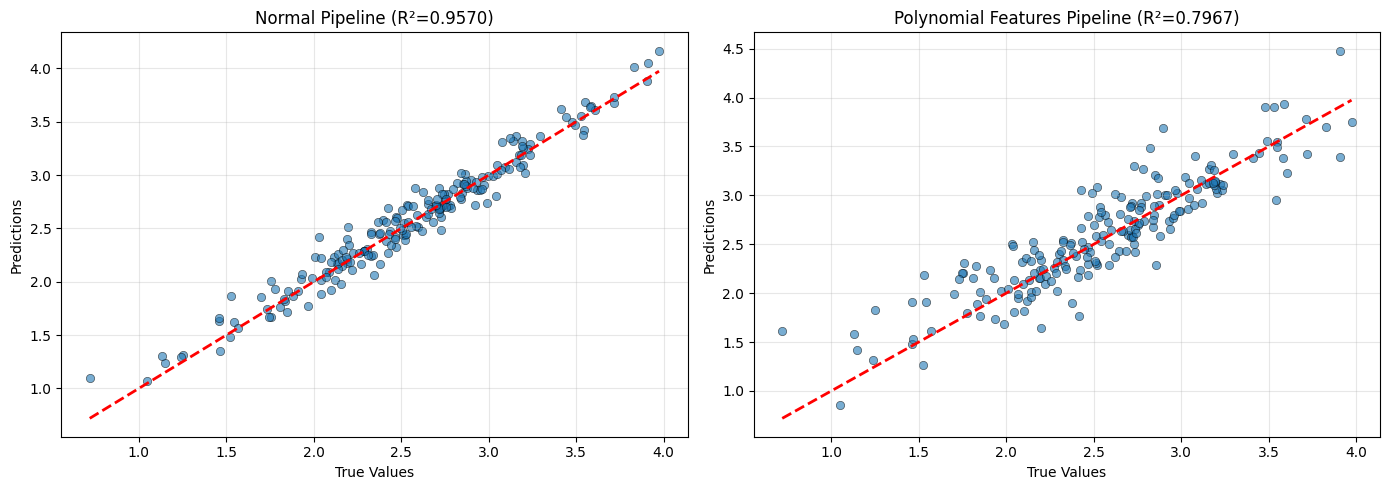

In [9]:
# 予測結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 通常のパイプライン
axes[0].scatter(y_test_h, y_pred_normal, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', lw=2)
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predictions')
axes[0].set_title(f'Normal Pipeline (R²={r2_normal:.4f})')
axes[0].grid(True, alpha=0.3)

# 多項式特徴量パイプライン
axes[1].scatter(y_test_h, y_pred_poly, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', lw=2)
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predictions')
axes[1].set_title(f'Polynomial Features Pipeline (R²={r2_poly:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. モデルの永続化（保存と読み込み）

### joblibを使ったモデル保存
学習済みモデルを保存することで、後で再利用したり本番環境にデプロイしたりできます。

In [10]:
# モデル保存用ディレクトリの作成
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# タイムスタンプ付きのモデル名
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = os.path.join(model_dir, f'breast_cancer_classifier_{timestamp}.pkl')

# モデル保存
joblib.dump(best_pipeline, model_filename)
print(f"モデルを保存しました: {model_filename}")

# ファイルサイズの確認
file_size = os.path.getsize(model_filename) / 1024  # KB
print(f"ファイルサイズ: {file_size:.2f} KB")

モデルを保存しました: ../models/breast_cancer_classifier_20251219_004349.pkl
ファイルサイズ: 65.16 KB


In [11]:
# モデルの読み込み
loaded_pipeline = joblib.load(model_filename)
print("モデルを読み込みました")

# 読み込んだモデルで予測
y_pred_loaded = loaded_pipeline.predict(X_test_c)
accuracy_loaded = loaded_pipeline.score(X_test_c, y_test_c)

print(f"\n読み込んだモデルの精度: {accuracy_loaded:.4f}")
print(f"元のモデルの精度: {accuracy_tuned:.4f}")
print(f"予測結果が一致: {np.array_equal(y_pred_loaded, y_pred_tuned)}")

モデルを読み込みました

読み込んだモデルの精度: 0.9561
元のモデルの精度: 0.9561
予測結果が一致: True


## 5. 本番環境向けの予測関数

### 堅牢な予測関数の実装
本番環境では、エラーハンドリングやバリデーションが重要です。

In [12]:
class ModelPredictor:
    """本番環境向けのモデル予測クラス"""
    
    def __init__(self, model_path, feature_names=None):
        """
        Parameters:
        -----------
        model_path : str
            学習済みモデルのパス
        feature_names : list, optional
            期待される特徴量名のリスト
        """
        self.model = joblib.load(model_path)
        self.feature_names = feature_names
        print(f"モデルを読み込みました: {model_path}")
    
    def validate_input(self, X):
        """入力データのバリデーション"""
        # DataFrameの場合
        if isinstance(X, pd.DataFrame):
            if self.feature_names is not None:
                # 特徴量名の確認
                if not all(col in X.columns for col in self.feature_names):
                    missing = set(self.feature_names) - set(X.columns)
                    raise ValueError(f"不足している特徴量: {missing}")
                # 特徴量の順序を揃える
                X = X[self.feature_names]
        
        # NumPy配列の場合
        elif isinstance(X, np.ndarray):
            if self.feature_names is not None:
                if X.shape[1] != len(self.feature_names):
                    raise ValueError(
                        f"特徴量数が一致しません。期待: {len(self.feature_names)}, 実際: {X.shape[1]}"
                    )
        else:
            raise TypeError("入力はpandas DataFrameまたはNumPy配列である必要があります")
        
        # 欠損値チェック
        if isinstance(X, pd.DataFrame):
            if X.isnull().any().any():
                raise ValueError("入力データに欠損値が含まれています")
        else:
            if np.isnan(X).any():
                raise ValueError("入力データに欠損値が含まれています")
        
        return X
    
    def predict(self, X):
        """予測を実行"""
        try:
            X = self.validate_input(X)
            predictions = self.model.predict(X)
            return predictions
        except Exception as e:
            print(f"予測エラー: {e}")
            raise
    
    def predict_proba(self, X):
        """確率予測を実行（分類モデルの場合）"""
        try:
            X = self.validate_input(X)
            if hasattr(self.model, 'predict_proba'):
                probabilities = self.model.predict_proba(X)
                return probabilities
            else:
                raise AttributeError("このモデルは確率予測をサポートしていません")
        except Exception as e:
            print(f"確率予測エラー: {e}")
            raise
    
    def get_model_info(self):
        """モデル情報の取得"""
        info = {
            'model_type': type(self.model).__name__,
            'feature_count': len(self.feature_names) if self.feature_names else 'Unknown'
        }
        
        # Pipelineの場合、ステップ情報を追加
        if hasattr(self.model, 'steps'):
            info['pipeline_steps'] = [step[0] for step in self.model.steps]
        
        return info

In [13]:
# ModelPredictorの使用例
predictor = ModelPredictor(
    model_path=model_filename,
    feature_names=cancer_data.feature_names.tolist()
)

# モデル情報の表示
print("\nモデル情報:")
for key, value in predictor.get_model_info().items():
    print(f"  {key}: {value}")

モデルを読み込みました: ../models/breast_cancer_classifier_20251219_004349.pkl

モデル情報:
  model_type: Pipeline
  feature_count: 30
  pipeline_steps: ['scaler', 'classifier']


In [14]:
# 単一サンプルの予測
sample_data = X_test_c.iloc[:5]  # 最初の5サンプル

predictions = predictor.predict(sample_data)
probabilities = predictor.predict_proba(sample_data)

print("予測結果:")
for i, (pred, proba) in enumerate(zip(predictions, probabilities)):
    print(f"サンプル {i+1}: 予測={cancer_data.target_names[pred]}, 確率={proba[pred]:.4f}")

予測結果:
サンプル 1: 予測=malignant, 確率=1.0000
サンプル 2: 予測=benign, 確率=1.0000
サンプル 3: 予測=malignant, 確率=0.9998
サンプル 4: 予測=malignant, 確率=0.8541
サンプル 5: 予測=malignant, 確率=1.0000


In [15]:
# エラーハンドリングのテスト

# 1. 欠損値を含むデータ
sample_with_nan = sample_data.copy()
sample_with_nan.iloc[0, 0] = np.nan

try:
    predictor.predict(sample_with_nan)
except ValueError as e:
    print(f"期待通りのエラー: {e}")

# 2. 特徴量が不足しているデータ
sample_missing_features = sample_data.iloc[:, :10]  # 最初の10特徴量のみ

try:
    predictor.predict(sample_missing_features)
except ValueError as e:
    print(f"期待通りのエラー: {e}")

予測エラー: 入力データに欠損値が含まれています
期待通りのエラー: 入力データに欠損値が含まれています
予測エラー: 不足している特徴量: {'fractal dimension error', 'perimeter error', 'worst concavity', 'smoothness error', 'worst compactness', 'compactness error', 'concavity error', 'worst fractal dimension', 'worst area', 'area error', 'texture error', 'worst perimeter', 'worst symmetry', 'worst texture', 'radius error', 'worst smoothness', 'concave points error', 'symmetry error', 'worst concave points', 'worst radius'}
期待通りのエラー: 不足している特徴量: {'fractal dimension error', 'perimeter error', 'worst concavity', 'smoothness error', 'worst compactness', 'compactness error', 'concavity error', 'worst fractal dimension', 'worst area', 'area error', 'texture error', 'worst perimeter', 'worst symmetry', 'worst texture', 'radius error', 'worst smoothness', 'concave points error', 'symmetry error', 'worst concave points', 'worst radius'}


## 6. 完全なMLワークフローの例

### データ読み込みからデプロイまでの全ステップ

In [16]:
def complete_ml_workflow(X, y, test_size=0.2, model_name='ml_model'):
    """
    完全な機械学習ワークフロー
    
    Parameters:
    -----------
    X : array-like or DataFrame
        特徴量データ
    y : array-like
        ターゲット変数
    test_size : float
        テストデータの割合
    model_name : str
        保存するモデルの名前
    
    Returns:
    --------
    dict : ワークフローの結果
    """
    print("=" * 60)
    print("完全なMLワークフロー開始")
    print("=" * 60)
    
    # ステップ1: データ分割
    print("\n[1/6] データ分割...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    print(f"  訓練データ: {X_train.shape[0]} サンプル")
    print(f"  テストデータ: {X_test.shape[0]} サンプル")
    
    # ステップ2: パイプライン構築
    print("\n[2/6] パイプライン構築...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    print("  パイプラインステップ:", [step[0] for step in pipeline.steps])
    
    # ステップ3: Cross-validation
    print("\n[3/6] Cross-validation...")
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f"  CVスコア: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # ステップ4: モデル学習
    print("\n[4/6] モデル学習...")
    pipeline.fit(X_train, y_train)
    print("  学習完了")
    
    # ステップ5: モデル評価
    print("\n[5/6] モデル評価...")
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    print(f"  訓練スコア: {train_score:.4f}")
    print(f"  テストスコア: {test_score:.4f}")
    
    # ステップ6: モデル保存
    print("\n[6/6] モデル保存...")
    model_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(pipeline, model_path)
    print(f"  保存先: {model_path}")
    
    print("\n" + "=" * 60)
    print("ワークフロー完了")
    print("=" * 60)
    
    return {
        'pipeline': pipeline,
        'cv_scores': cv_scores,
        'train_score': train_score,
        'test_score': test_score,
        'model_path': model_path,
        'X_test': X_test,
        'y_test': y_test
    }

In [17]:
# 完全ワークフローの実行
workflow_result = complete_ml_workflow(
    X=X_cancer,
    y=y_cancer,
    test_size=0.2,
    model_name='breast_cancer_rf_pipeline'
)

完全なMLワークフロー開始

[1/6] データ分割...
  訓練データ: 455 サンプル
  テストデータ: 114 サンプル

[2/6] パイプライン構築...
  パイプラインステップ: ['scaler', 'classifier']

[3/6] Cross-validation...


  CVスコア: 0.9582 (+/- 0.0352)

[4/6] モデル学習...
  学習完了

[5/6] モデル評価...
  訓練スコア: 1.0000
  テストスコア: 0.9649

[6/6] モデル保存...


  保存先: ../models/breast_cancer_rf_pipeline.pkl

ワークフロー完了


モデルを読み込みました: ../models/breast_cancer_rf_pipeline.pkl


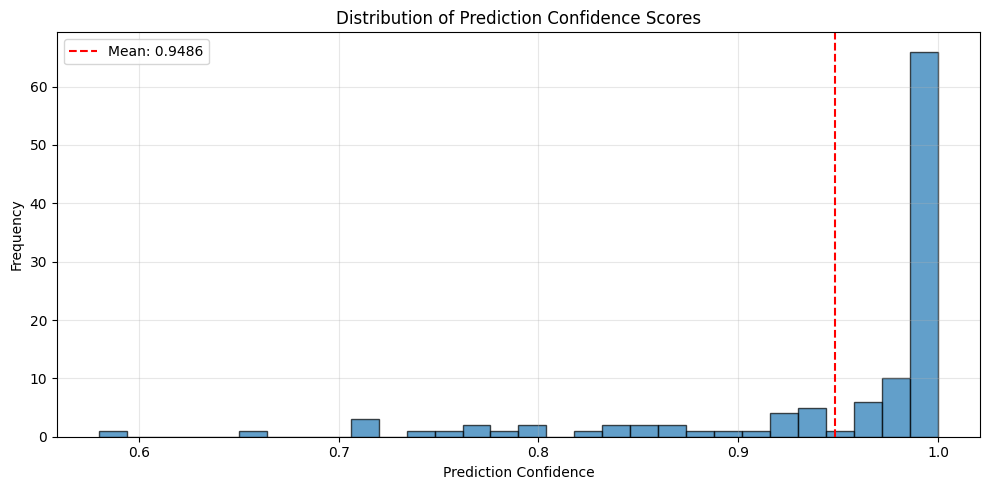

平均信頼度: 0.9486
最小信頼度: 0.5800
最大信頼度: 1.0000


In [18]:
# 保存したモデルを使った予測
production_predictor = ModelPredictor(
    model_path=workflow_result['model_path'],
    feature_names=cancer_data.feature_names.tolist()
)

# テストデータで予測
test_predictions = production_predictor.predict(workflow_result['X_test'])
test_probabilities = production_predictor.predict_proba(workflow_result['X_test'])

# 予測の信頼度分布
confidence_scores = np.max(test_probabilities, axis=1)

plt.figure(figsize=(10, 5))
plt.hist(confidence_scores, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence Scores')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', 
            label=f'Mean: {confidence_scores.mean():.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"平均信頼度: {confidence_scores.mean():.4f}")
print(f"最小信頼度: {confidence_scores.min():.4f}")
print(f"最大信頼度: {confidence_scores.max():.4f}")

## 7. ベストプラクティスとチェックリスト

### データ準備
- [ ] データの品質チェック（欠損値、外れ値、データ型）
- [ ] 適切なtrain/test分割（stratify、random_state）
- [ ] 特徴量スケーリングの必要性確認

### モデル開発
- [ ] Pipelineを使用して前処理とモデルを統合
- [ ] Cross-validationで汎化性能を評価
- [ ] ハイパーパラメータチューニング実施
- [ ] 過学習の確認（train vs test スコア）

### モデル評価
- [ ] 適切な評価指標の選択
- [ ] 混同行列や学習曲線での詳細分析
- [ ] 誤分類サンプルの分析

### デプロイ準備
- [ ] モデルをjoblibで保存
- [ ] 予測関数にバリデーション機能を実装
- [ ] エラーハンドリングの実装
- [ ] モデルのバージョン管理
- [ ] ドキュメント作成（モデルの使用方法、入力形式など）

## 8. まとめ

### 本ノートブックで学んだこと

1. **Pipelineの基礎**
   - 前処理とモデルを一つのワークフローに統合
   - データリーク防止と再現性の向上

2. **パイプライン内でのチューニング**
   - `<ステップ名>__<パラメータ名>` 形式でのパラメータ指定
   - GridSearchCVでの一括最適化

3. **特徴量エンジニアリング**
   - PolynomialFeaturesなどの変換をパイプラインに組み込み
   - 複雑な前処理フローの構築

4. **モデルの永続化**
   - joblibを使った保存と読み込み
   - バージョン管理のためのタイムスタンプ付与

5. **本番環境向け実装**
   - 入力バリデーション機能
   - エラーハンドリング
   - 予測の信頼度評価

6. **完全なワークフロー**
   - データ準備から評価、保存までの全ステップ
   - 再利用可能な関数の実装

### 次のステップ
- APIサーバーでのモデル提供（Flask, FastAPI）
- モデルのモニタリングとA/Bテスト
- MLOpsツールの活用（MLflow, DVC等）
- より高度なアンサンブル手法の実装